In [ ]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests

In [3]:
# PARAMETERS
run_id="DMRs.07.23.ldcts"

In [ ]:
traits = {"Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia" : "Alzheimers Disease and Dementia", 
          "Nalls.LancetNeurol.2019.Parkinsons_disease" : "Parkinson's Disease", 
          "PGC.Nature.2014.Schizophrenia" : "Schizophrenia",
          "Wray.biorxiv.2018.Major_Depressive_Disorder" : "Major Depressive Disorder", 
          "Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder" : "ADHD", 
          "Mullins.NatGenet.2021.Bipolar_Disorder" : "Bipolar Disorder", 
          "Grove.NatGenet.2019.Autism_Spectrum_Disorder" : "Autism Spectrum Disorder", 
          "Jansen.2019.NatGenet.Insomnia" : "Insomnia", 
          "PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder" : "Obsessive Compulsive Disorder",
          "Deary.MolPsychiatry.2017.Tiredness" : "Tiredness", 
          "IMSGC.Science.2019.Multiple_sclerosis" : "Muliple Sclerosis", 
          "Luciano.NatGenet.2017.Neuroticism" : "Neuroticism", 
          "Okbay.Nature.2016.Educational_Attainment" : "Educational Attainment", 
          "Palmer.MolPsych.2021.problematic_opioid_use" : "Problematic Opioid Use", 
          "Savage.NatGenet.2018.Intelligence" : "Intelligence", 
          "vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis" : "Amyotrophic Lateral Sclerosis", 
          "Barban.NatGenet.2016.Age_First_Birth" : "Age First Birth", 
          "Chiou.Nature.2021.Type_1_diabetes" : "Type 1 Diabetes",
          "Watson.2018.NatGenet.Anorexia_Nervosa" : "Anorexia Nervosa"
        }

In [4]:
ldsc_results=f'/anvil/projects/x-mcb130189/rwang22/bican/ldsc/output/{run_id}'
directory = Path(ldsc_results)
dfs = {}

for file in directory.glob(f'*.cell_type_results.txt'):
    cur = pd.read_csv(file, sep = "\t")
    stripped = file.stem.replace(f'_.cell_type_results', "")
    cur["Trait"] = stripped
    dfs[stripped] = cur

In [5]:
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df["-log10(pval)"] = -np.log10(combined_df["Coefficient_P_value"])
combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")
combined_df.head()

/tmp/ipykernel_3017778/1445883874.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")


,Name,Coefficient,Coefficient_std_error,Coefficient_P_value,Trait,-log10(pval)
0,Glut,7.277171e-08,1.361690e-08,4.540380e-08,PASS_Intelligence_SavageJansen2018_,7.342908
1,CN_MEIS2_GABA,5.675921e-08,1.671118e-08,3.412913e-04,PASS_Intelligence_SavageJansen2018_,3.466875
2,STR_Hybrid_MSN,3.612909e-08,1.074142e-08,3.847626e-04,PASS_Intelligence_SavageJansen2018_,3.414807
3,F_Glut,4.932086e-08,1.678963e-08,1.653933e-03,PASS_Intelligence_SavageJansen2018_,2.781482
4,STR_D2_MSN,3.681312e-08,1.309298e-08,2.464259e-03,PASS_Intelligence_SavageJansen2018_,2.608314


In [ ]:
# Perform FDR correction using Benjamini-Hochberg procedure
rejected, q_values, _, _ = multipletests(combined_df["Coefficient_P_value"], alpha=0.05, method='fdr_bh')
combined_df["FDR_BH_corrected"] = q_values

In [ ]:
# calculate the FDR p value threshold 
# https://www.r-bloggers.com/2023/07/the-benjamini-hochberg-procedure-fdr-and-p-value-adjusted-explained/

def fdr_bh_adj(df):
    tmp = combined_df.copy()
    tmp["rank"] =  combined_df['Coefficient_P_value'].rank()
    num_tests = len(tmp)
    tmp["adj_pval"] = (num_tests * tmp["Coefficient_P_value"]) / tmp["rank"]

    return tmp


In [32]:
tmp = fdr_bh_adj(combined_df)
# Align indices before comparison
fdr_bh_corrected = combined_df["FDR_BH_corrected"]
adj_pval = tmp["adj_pval"]

print(fdr_bh_corrected.sort_values())

96     8.784290e-07
0      9.443990e-06
224    1.122262e-03
288    3.699607e-03
384    5.814780e-03
           ...     
383    9.949972e-01
158    9.949972e-01
415    9.949972e-01
222    9.954372e-01
223    9.980986e-01
Name: FDR_BH_corrected, Length: 416, dtype: float64


In [33]:
print(adj_pval.sort_values())

96     8.784290e-07
0      9.443990e-06
224    1.122262e-03
288    3.699607e-03
384    5.814780e-03
           ...     
219    1.002031e+00
351    1.002512e+00
156    1.003203e+00
95     1.003260e+00
287    1.004401e+00
Name: adj_pval, Length: 416, dtype: float64


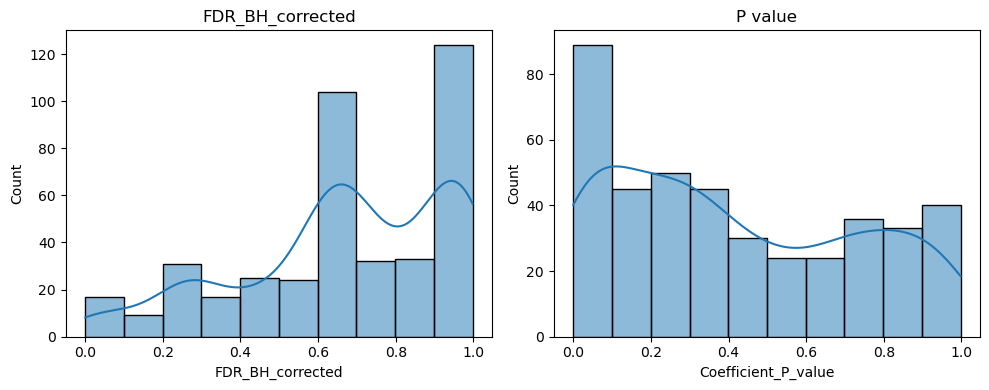

In [11]:
# plot the distribution of p values 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First plot
sns.histplot(combined_df["FDR_BH_corrected"], kde=True, ax=axes[0])
axes[0].set_title("FDR_BH_corrected")

# Second plot
sns.histplot(combined_df["Coefficient_P_value"], kde=True, ax=axes[1])
axes[1].set_title("P value")

plt.tight_layout()
plt.show()

In [13]:
modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', 'FDR_BH_corrected'], axis=1)
modified_df = modified_df.pivot(index="Name", columns="Trait", values="-log10(pval)").reset_index()
modified_df = modified_df.set_index("Name")
modified_df.head()

Trait,PASS_ADHD_Demontis2018_,PASS_Alzheimers_Jansen2019_,PASS_Autism_Grove2019_,PASS_BIP_Stahl2019_,PASS_Epilepsy_Anney_2014_,PASS_Insomnia_Jansen2019_,PASS_Intelligence_SavageJansen2018_,PASS_MDD_Wray2018_,PASS_Multiple_sclerosis_,PASS_Parkinsons_23andMe_Corces2020_,PASS_Schizophrenia_,PASS_Years_of_Education2_,UKB_460K.mental_NEUROTICISM_
Name,,,,,,,,,,,,,
ACx_MEIS2_GABA,0.041082,0.330969,0.163917,0.096570,0.061510,0.360299,0.427436,0.392599,0.019487,0.591514,0.374020,0.319169,0.289414
Astrocyte,1.259112,0.007020,0.835315,1.475069,0.505032,0.084725,1.038324,0.967049,0.213813,0.212079,0.573725,0.006816,0.154884
CN_Cholinergic_GABA,0.485334,0.081974,0.189849,0.041918,0.217334,0.361066,0.622993,0.591276,0.019122,1.212549,0.970762,0.391004,0.772502
CN_GABA-Glut,0.038014,1.045237,0.947555,0.147675,0.785237,0.041580,1.850312,0.244744,0.023617,1.314114,0.338898,0.116179,0.510616
CN_LAMP5-CXCL14_GABA,0.045059,0.172392,0.053818,0.613683,0.523187,0.504504,0.439212,1.079106,0.027606,0.306521,0.461491,0.274561,0.443360


In [14]:
fdr_modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', '-log10(pval)'], axis=1)
fdr_modified_df = fdr_modified_df.pivot(index="Name", columns="Trait", values="FDR_BH_corrected").reset_index()
fdr_modified_df = fdr_modified_df.set_index("Name")
fdr_modified_df.head()

Trait,PASS_ADHD_Demontis2018_,PASS_Alzheimers_Jansen2019_,PASS_Autism_Grove2019_,PASS_BIP_Stahl2019_,PASS_Epilepsy_Anney_2014_,PASS_Insomnia_Jansen2019_,PASS_Intelligence_SavageJansen2018_,PASS_MDD_Wray2018_,PASS_Multiple_sclerosis_,PASS_Parkinsons_23andMe_Corces2020_,PASS_Schizophrenia_,PASS_Years_of_Education2_,UKB_460K.mental_NEUROTICISM_
Name,,,,,,,,,,,,,
ACx_MEIS2_GABA,0.985105,0.770414,0.929192,0.959219,0.973622,0.740677,0.692540,0.722560,0.994997,0.632208,0.740677,0.788504,0.812314
Astrocyte,0.338147,0.994997,0.562229,0.265593,0.677600,0.964664,0.441925,0.480724,0.885016,0.885016,0.639583,0.994997,0.929192
CN_Cholinergic_GABA,0.678101,0.964664,0.904665,0.985105,0.884942,0.740677,0.632208,0.632208,0.994997,0.357136,0.480724,0.722560,0.585012
CN_GABA-Glut,0.985105,0.441925,0.482213,0.929192,0.581370,0.985105,0.217479,0.851735,0.994904,0.320360,0.768810,0.944678,0.677600
CN_LAMP5-CXCL14_GABA,0.985105,0.928637,0.982661,0.632208,0.674117,0.677600,0.692540,0.438894,0.990811,0.795569,0.678101,0.815760,0.690675


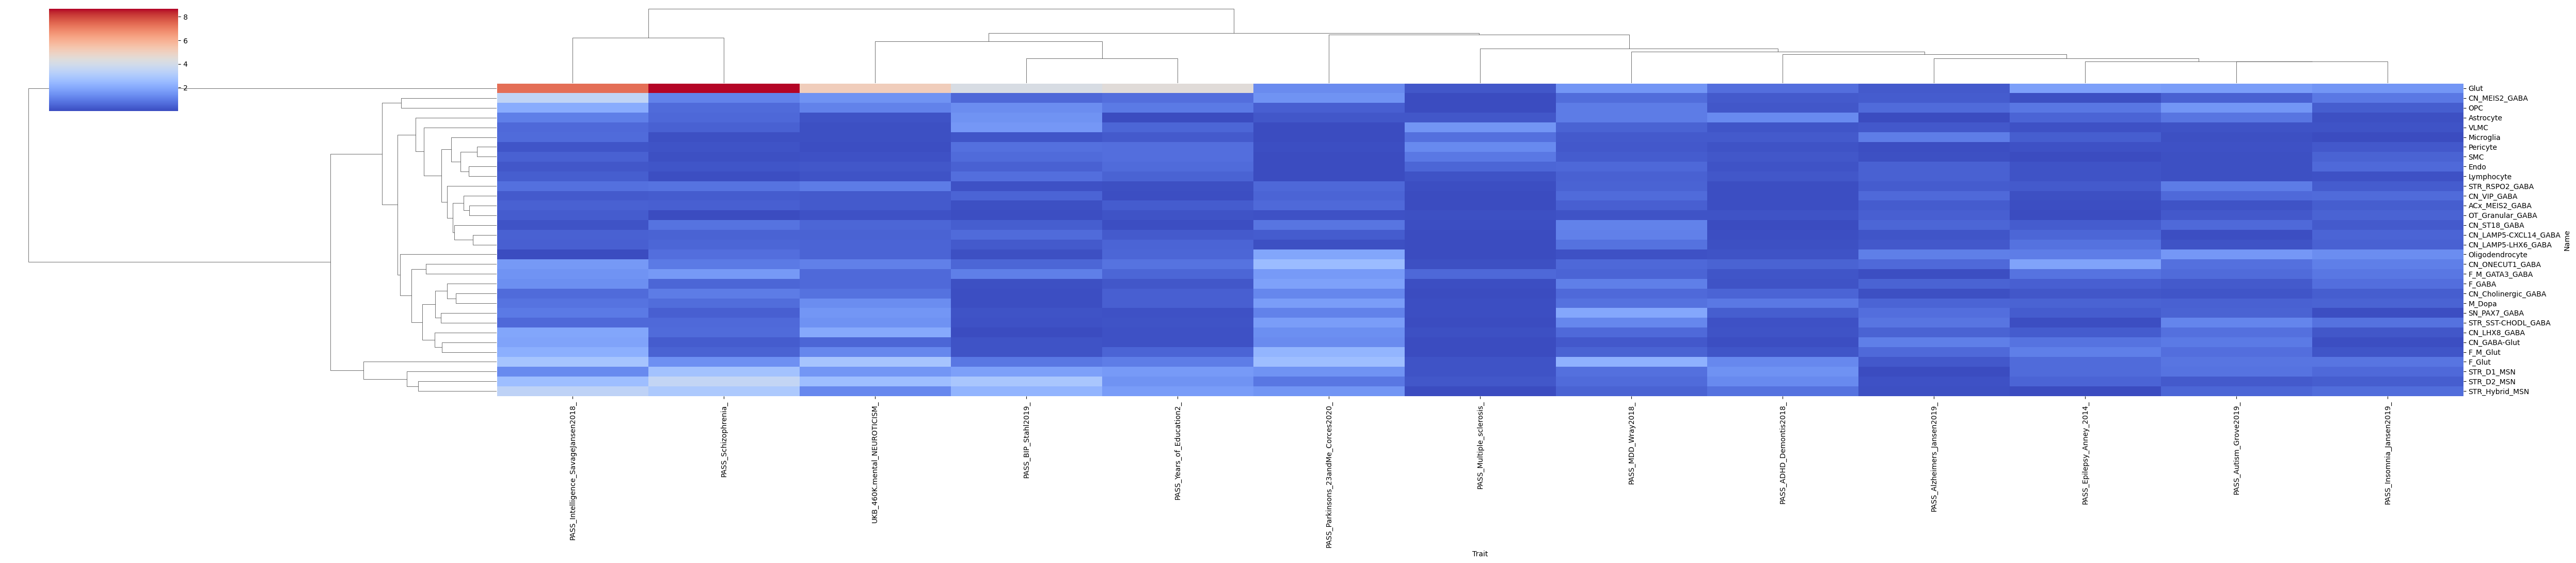

In [ ]:
g = sns.clustermap(modified_df, cmap='coolwarm', figsize=(50, 11))

plt.show()
g.savefig(f'output/{run_id}.pdf')

In [15]:
def pval_to_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

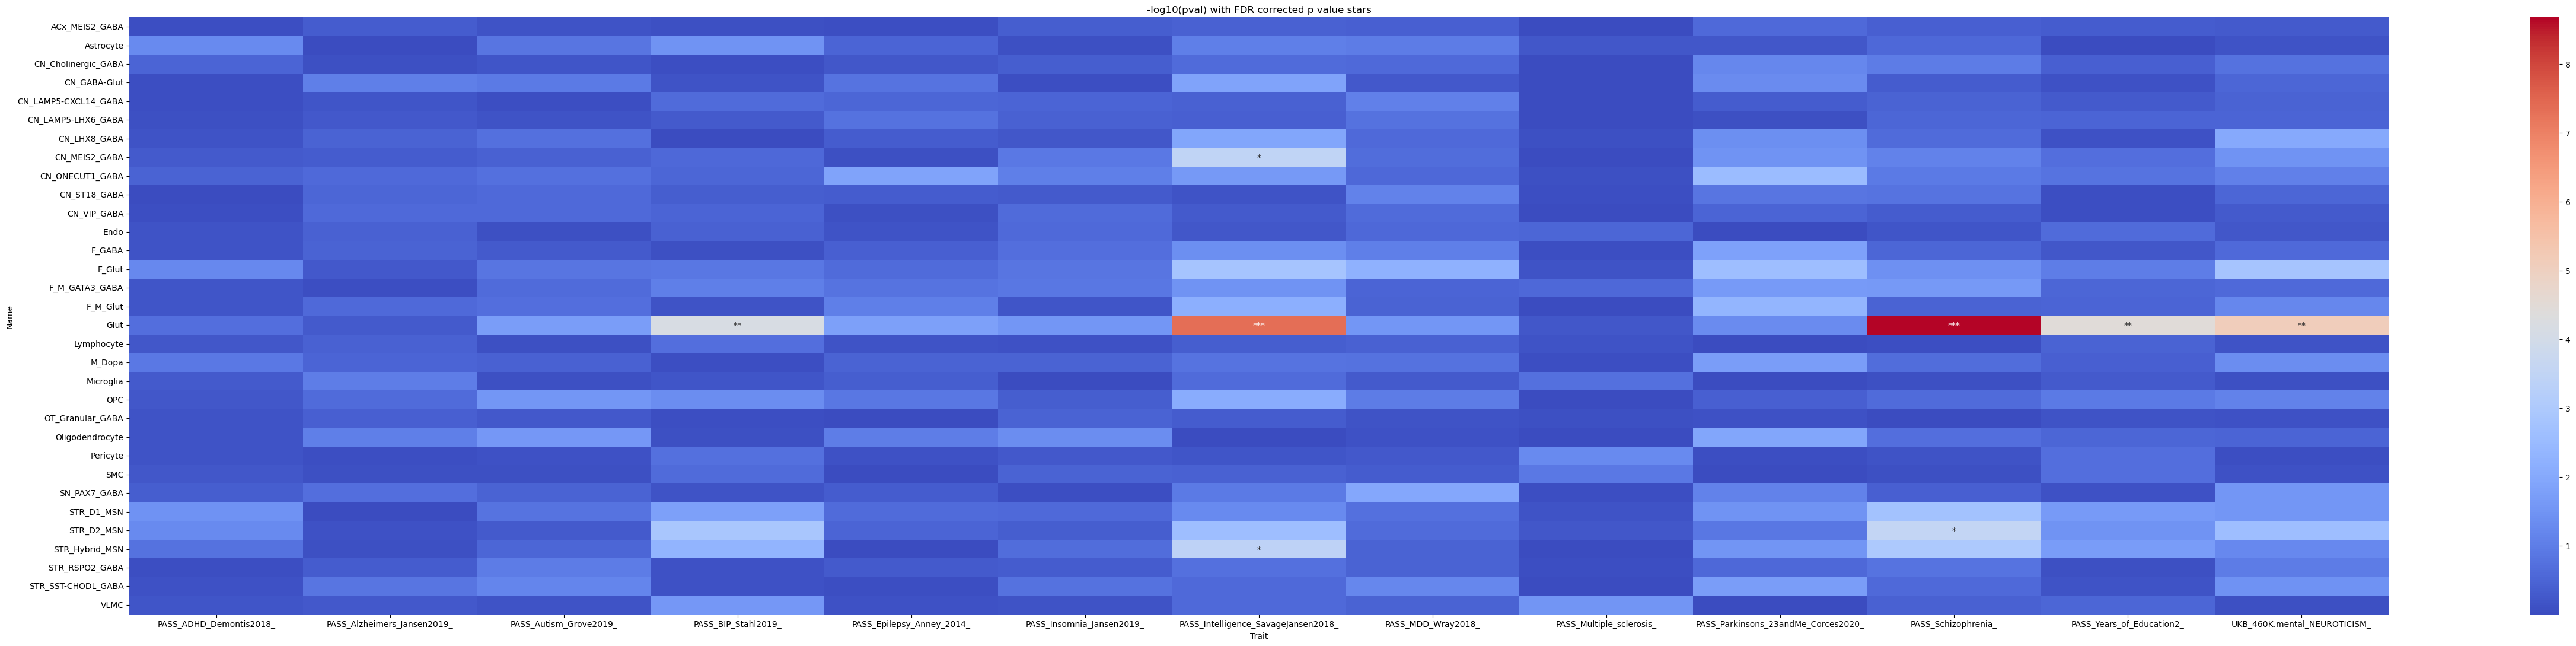

In [ ]:
stars = fdr_modified_df.applymap(pval_to_star)

# Plot heatmap with annotations
plt.figure(figsize=(50, 11))
sns.heatmap(modified_df, annot=stars, fmt='', cmap='coolwarm')
plt.title("-log10(pval) with FDR corrected p value stars")
plt.tight_layout()
plt.savefig(f'output/{run_id}_FDR_corrected.pdf')
plt.show()

